In [127]:
import torch

# function: y = x1^3 + 6

def f(x: torch.tensor) -> torch.tensor:
    """
    Function to compute the value of the polynomial y = x1^3 + 5*x1^2 - 0.1*x1^6 + 45*sin(5*x1) + 6.
    """
    return x**3 + 6

# test the function
print(f"{f(torch.tensor([3]))=}")

f(torch.tensor([3]))=tensor([33])


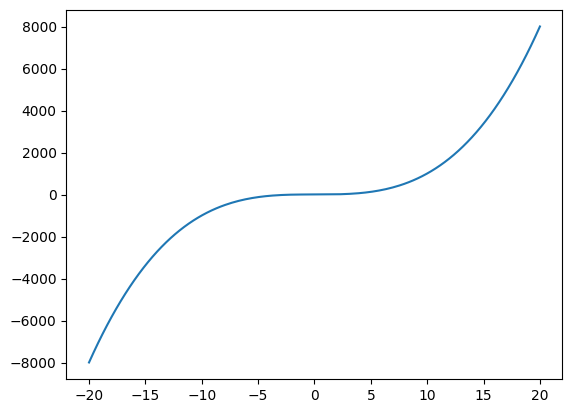

In [128]:
# plot the function
import matplotlib.pyplot as plt

X1 = torch.linspace(-20, 20, 200)
Y = f(X1)
plt.plot(X1, Y)

In [129]:
def f_plus_error(x: torch.tensor, err_scale: float) -> torch.tensor:
    """
    Function to compute the value of the polynomial y = x1^3 + 6
    with a small error added.
    """
    return f(x) + torch.normal(0, err_scale, size=x.shape)

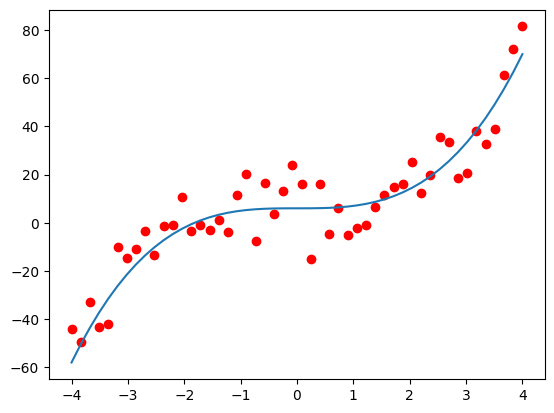

In [256]:
# plot the function plus data points with error
X1 = torch.linspace(-4, 4, 50)
Y = f(X1)
Yerr = f_plus_error(X1, 10)

plt.plot(X1, Y)
plt.scatter(X1, Yerr, color='red')

In [352]:
from torch.utils.data import DataLoader

x_train = torch.linspace(-4, 4, 30).unsqueeze(1)
train_data = list(zip(x_train, f_plus_error(x_train, 10)))

x_test = torch.linspace(-4, 4, 20).unsqueeze(1)
test_data = list(zip(x_test, f_plus_error(x_test, 10)))


train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=True)

In [353]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features, train_labels)

tensor([[-1.2414],
        [-2.6207]]) tensor([[ 19.4321],
        [-31.8649]])


In [382]:
from torch import nn

INPUT_SIZE = 1
HIDDEN_LAYER = 6
OUTPUT_SIZE = 1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_LAYER),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER, OUTPUT_SIZE),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [383]:
learning_rate = 1e-4

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [384]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # Set the gradients to zero after the optimizer step
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [385]:
batch_size = 2
epochs = 1000

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, batch_size)
    train_losses.append(test_loop(train_dataloader, model, loss_fn))
    test_losses.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 562.496399  [    2/   30]
Test Error: 
 Avg loss: 911.264023 

Test Error: 
 Avg loss: 812.944257 

Epoch 2
-------------------------------
loss: 289.642944  [    2/   30]
Test Error: 
 Avg loss: 908.714817 

Test Error: 
 Avg loss: 810.706322 

Epoch 3
-------------------------------
loss: 1024.183960  [    2/   30]
Test Error: 
 Avg loss: 906.087397 

Test Error: 
 Avg loss: 808.407787 

Epoch 4
-------------------------------
loss: 251.593353  [    2/   30]
Test Error: 
 Avg loss: 903.282745 

Test Error: 
 Avg loss: 805.946240 

Epoch 5
-------------------------------
loss: 235.739746  [    2/   30]
Test Error: 
 Avg loss: 900.138509 

Test Error: 
 Avg loss: 803.193817 

Epoch 6
-------------------------------
loss: 2681.949463  [    2/   30]
Test Error: 
 Avg loss: 896.504960 

Test Error: 
 Avg loss: 799.995014 

Epoch 7
-------------------------------
loss: 2658.239014  [    2/   30]
Test Error: 
 Avg loss: 892.103187 

Test Error: 

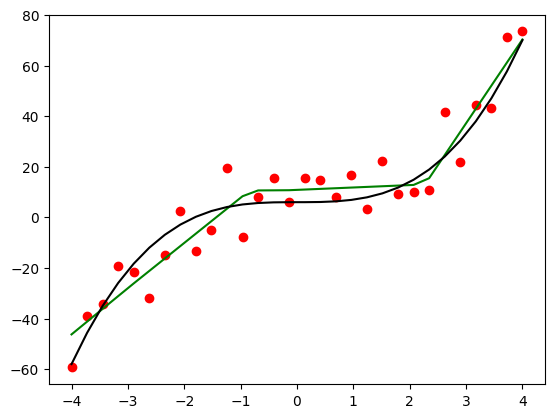

In [386]:
model.eval()
with torch.no_grad():
    # plot the results
    y = model(x_train)
plt.plot(x_train, y, color="green", label='NN Prediction')
y_true = [x[1] for x in train_data]
plt.scatter(x_train, y_true, color='red', label='Data with Error')
plt.plot(x_train, f(x_train), color="black", label='True Function')

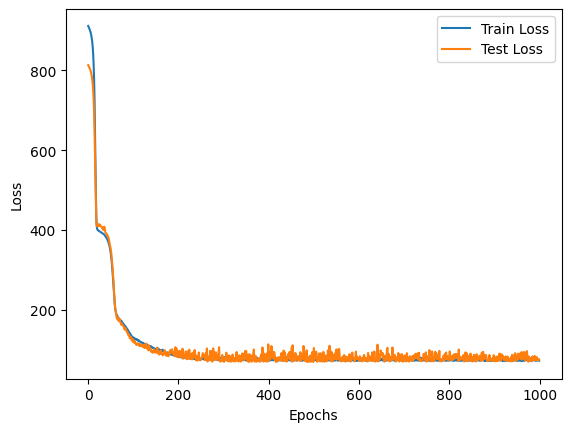

In [387]:
# plot the loss functions
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()